<a href="https://colab.research.google.com/github/ryanjameskim/public/blob/master/Kaggle_Tabular_Mar_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing and Data upload

In [ ]:
# Import OS for navigation and environment set up
import os

# Import Numpy
import numpy as np

# Import Pandas
import pandas as pd

# Needed for cleaner code
from functools import partial

# Import graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go

# Import encoding libraries
from sklearn.preprocessing import LabelEncoder
from copy import deepcopy
!pip install category_encoders
from category_encoders import CatBoostEncoder, LeaveOneOutEncoder

# Import baseline models and other tools
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.linear_model import RidgeClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# Import for Ensemble Second Level Classification
from scipy.special import expit
from sklearn.calibration import CalibratedClassifierCV

# Import cross validation tools
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Import measurement tools
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score, mean_squared_error

# Import Optuna for tuning
!pip install optuna
import optuna

#mount google drive
from google.colab import drive
drive.mount('/gdrive')

     |████████████████████████████████| 296kB 7.3MB/s 
     |████████████████████████████████| 163kB 12.8MB/s 
     |████████████████████████████████| 81kB 7.8MB/s 
     |████████████████████████████████| 81kB 8.0MB/s 
     |████████████████████████████████| 112kB 9.0MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 143kB 12.8MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=9e50df6e45efa660c86562056da6dfd12dca5501da1bcd765dc37724584929cb
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# Enable the Kaggle environment, use the path to the directory your Kaggle API JSON is stored in
os.environ['KAGGLE_CONFIG_DIR'] = '/gdrive/MyDrive/Kaggle'

# install Kaggle library for kaggle terminal commands
!pip install kaggle


In [ ]:
#zip save directory
zip_dir = '/gdrive/MyDrive/Kaggle/Tabular Playground Series - Mar 2021'

#change directory to save zips
os.chdir(zip_dir)

!kaggle competitions download -c tabular-playground-series-mar-2021

train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Complete path to storage location of the .zip file of data
zip_files = []

#collect all zip files
for root, dirs, files in os.walk(zip_dir):
  for name in files:
    if 'zip' in name:
      zip_files.append(os.path.join(root, name))

# Change to colabs VM directory
os.chdir('/content')

#unzip
for zip_file in zip_files:
  !cp '{zip_file}' .
  root, name = os.path.split(zip_file)
  !unzip -q '{name}'

#show directory
os.listdir()

['.config',
 'test.csv.zip',
 'sample_submission.csv.zip',
 'test.csv',
 'sample_submission.csv',
 'train.csv',
 'train.csv.zip',
 'sample_data']

In [ ]:
sample_sub = pd.read_csv('sample_submission.csv')
print(sample_sub.head())
print(len(sample_sub))


   id  target
0   5     0.5
1   6     0.5
2   8     0.5
3   9     0.5
4  11     0.5
200000


In [ ]:
train = pd.read_csv('train.csv')

print(train.head())
print(len(train))

   id cat0 cat1 cat2 cat3  ...     cont7     cont8     cont9    cont10 target
0   0    A    I    A    B  ...  0.791921  0.815254  0.965006  0.665915      0
1   1    A    I    A    A  ...  0.408701  0.399353  0.927406  0.493729      0
2   2    A    K    A    A  ...  0.388835  0.412303  0.292696  0.549452      0
3   3    A    K    A    C  ...  0.897617  0.633669  0.760318  0.934242      0
4   4    A    I    G    B  ...  0.279167  0.351103  0.357084  0.328960      1

[5 rows x 32 columns]
300000


In [ ]:
test = pd.read_csv('test.csv')

In [ ]:
train.columns

Index(['id', 'cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7',
       'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15',
       'cat16', 'cat17', 'cat18', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4',
       'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'target'],
      dtype='object')

In [ ]:
train.target.value_counts()

train.target.value_counts().div(len(train))

0    0.73513
1    0.26487
Name: target, dtype: float64

In [ ]:
cat_columns = [col_name for col_name in train.columns if 'cat' in col_name]
cont_columns = [col_name for col_name in train.columns if 'cont' in col_name]

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cat0    300000 non-null  object 
 2   cat1    300000 non-null  object 
 3   cat2    300000 non-null  object 
 4   cat3    300000 non-null  object 
 5   cat4    300000 non-null  object 
 6   cat5    300000 non-null  object 
 7   cat6    300000 non-null  object 
 8   cat7    300000 non-null  object 
 9   cat8    300000 non-null  object 
 10  cat9    300000 non-null  object 
 11  cat10   300000 non-null  object 
 12  cat11   300000 non-null  object 
 13  cat12   300000 non-null  object 
 14  cat13   300000 non-null  object 
 15  cat14   300000 non-null  object 
 16  cat15   300000 non-null  object 
 17  cat16   300000 non-null  object 
 18  cat17   300000 non-null  object 
 19  cat18   300000 non-null  object 
 20  cont0   300000 non-null  float64
 21  cont1   30

#Data exploration

## Continuous Features

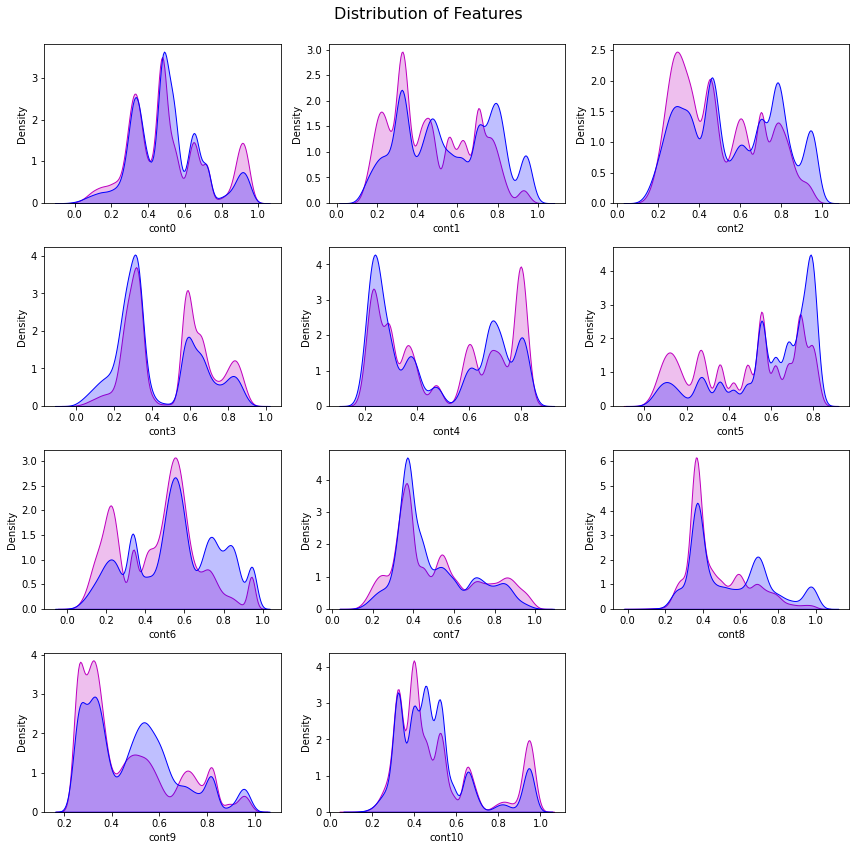

In [ ]:
#adapted from @AndresHG 

graph_rows, graph_cols = 4, 3
fig, axes = plt.subplots(nrows=graph_rows, ncols=graph_cols, figsize=(12,12))
fig.suptitle('Distribution of Features', fontsize=16)

for index, column in enumerate(train[cont_columns].columns):
  i, j = (index // graph_cols, index % graph_cols)
  sns.kdeplot(train.loc[train.target == 0, column], color='m', shade=True, ax=axes[i,j])
  sns.kdeplot(train.loc[train.target == 1, column], color='b', shade=True, ax=axes[i,j])

fig.delaxes(axes[3,2])
plt.tight_layout(pad=1.10, rect=(0,0,1,.95))
plt.show()

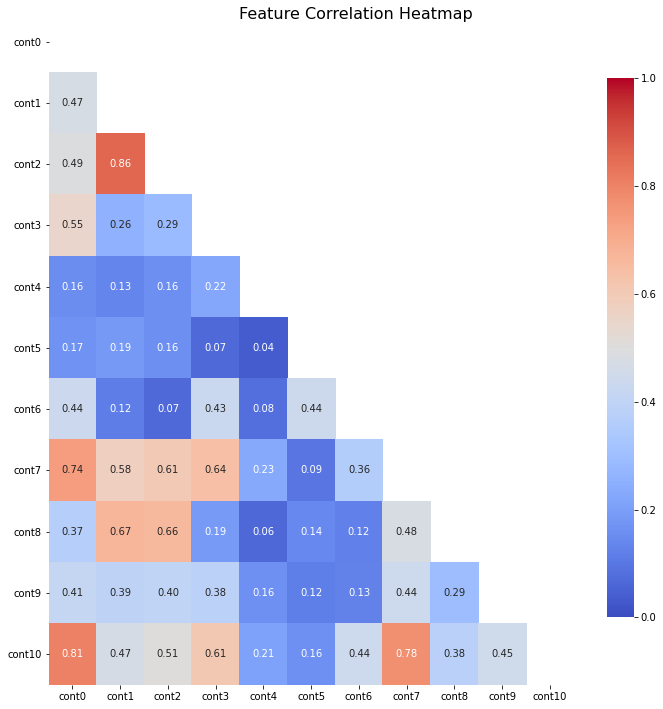

In [ ]:
#adapted from @AndresHG 

corr = train[cont_columns].corr().abs()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig, ax = plt.subplots(figsize=(10, 10))

fig.suptitle('Feature Correlation Heatmap', fontsize=16)

# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            cbar_kws={"shrink": .8}, vmin=0, vmax=1)
# yticks
plt.yticks(rotation=0)

plt.tight_layout(pad=1.10, rect=(0,0,1,.99))

plt.show()



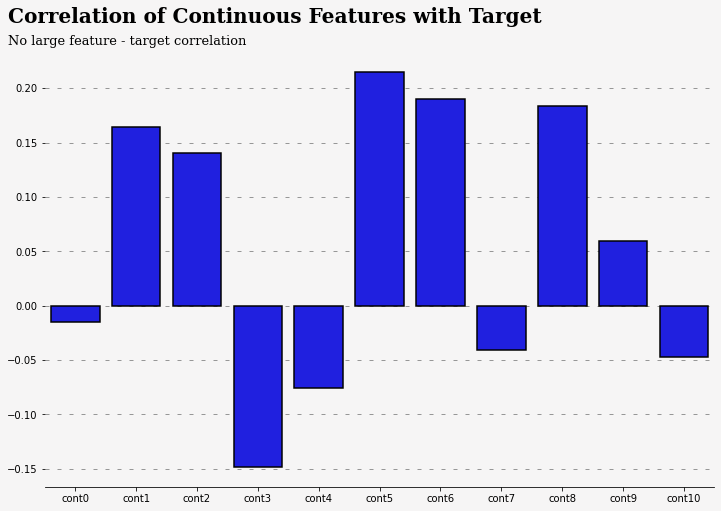

In [ ]:
#adapted from @dwin183287 via @AndresHG 

background_color = "#f6f5f5"

fig = plt.figure(figsize=(12, 8), facecolor=background_color)
gs = fig.add_gridspec(1, 1)
ax0 = fig.add_subplot(gs[0, 0])

ax0.set_facecolor(background_color)
ax0.text(-1.1, 0.26, 'Correlation of Continuous Features with Target',
         fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-1.1, 0.24, 'No large feature - target correlation',
         fontsize=13, fontweight='light', fontfamily='serif')

chart_df = pd.DataFrame(train[cont_columns].corrwith(train['target']))
chart_df.columns = ['corr']
sns.barplot(x=chart_df.index, y=chart_df['corr'], ax=ax0, color='blue',
            zorder=3, edgecolor='black', linewidth=1.5)
ax0.grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(5,10))
ax0.set_ylabel('')

for s in ["top","right", 'left']:
    ax0.spines[s].set_visible(False)

plt.show()

In [ ]:
chart_df

,corr
cont0,-0.015172
cont1,0.164655
cont2,0.140459
cont3,-0.148316
cont4,-0.075585
cont5,0.215184
cont6,0.189832
cont7,-0.040646
cont8,0.183726
cont9,0.059242


## Categorical Features

In [ ]:
for cat_col in cat_columns:
  print(train[cat_col].value_counts())

A    223525
B     76475
Name: cat0, dtype: int64
I    90809
F    43818
K    41870
L    31891
H    17257
N    13231
M    11354
G    11248
A    10547
J    10036
O     8740
B     6847
C     1703
D      414
E      235
Name: cat1, dtype: int64
A    168694
C     38875
D     22720
G     18225
Q     10901
F      9877
J      9102
M      8068
I      5287
L      3997
O      2749
N       340
H       219
B       218
S       197
U       166
R       129
K       126
E       110
Name: cat2, dtype: int64
A    187251
B     79951
C     15957
D      8676
E      3318
F      2489
K       846
G       372
L       292
J       286
H       274
I       177
N       111
Name: cat3, dtype: int64
E    129385
F     76678
G     30754
D     27919
H     23388
J      4307
I      3241
K      1481
M       547
C       506
O       330
B       301
S       285
T       215
L       214
Q       117
P       100
A        92
N        81
R        59
Name: cat4, dtype: int64
BI    238563
AB     41639
BU      6740
K       2713
G        6

In [ ]:
#adapted from @AndresHG 

train_0 = train.loc[train['target']==0]
train_1 = train.loc[train['target']==1]

graph_rows, graph_cols = 10,2
fig = plotly.subplots.make_subplots(rows=graph_rows, cols=graph_cols)

for index, feature in enumerate(cat_columns):
  i,j = ((index // graph_cols)+1, (index % graph_cols)+1)
  data = train_0.groupby(feature)[feature].count().sort_values(ascending=False)
  data = data if len(data) < 10 else data[:10]
  fig.add_trace(  go.Bar(x = data.index,
                          y = data.values,
                          name='Label: 0',),
                row=i, col=j)

  data = train_1.groupby(feature)[feature].count().sort_values(ascending=False)
  data = data if len(data) < 10 else data[:10]
  fig.add_trace(  go.Bar(x = data.index,
                          y = data.values,
                          name='Label: 1'),
                row=i, col=j)
  
  fig.update_xaxes(title=feature, row=i, col=j)
  fig.update_layout(barmode='stack')

fig.update_layout(
    autosize=False,
    width=1000,
    height=1600,
    showlegend=False,
)

fig.show()

In [ ]:
#adapted from @AndresHG 

num_rows, num_cols = 10,1
fig = plotly.subplots.make_subplots(rows=num_rows, cols=num_cols)
cont = 1

for index, feature in enumerate(cat_columns):
  data = train_0.groupby(feature)[feature].count().sort_values(ascending=False) #find values of feature for target 0
  if len(data) < 10:    #if less than 10, skip
      continue
  data = data if len(data) < 25 else data[:25]   #if greater than 25, choose largest 25
  i,j = (cont, 1)   #set place in graphing
  cont+=1
  
  fig.add_trace(  go.Bar(x = data.index,
                          y = data.values,
                          name='Label: 0',),
                row=i, col=j)
  
  target_0_values = set(data.index)  #make a set of all the categories which have target 0
  
  data = train_1.groupby(feature)[feature].count().sort_values(ascending=False)
  data = data if len(data) < 25 else data[:25]
  
  fig.add_trace(  go.Bar(x = data.index,
                          y = data.values,
                          name='Label: 1'),
                row=i, col=j)
  
  target_1_values = set(data.index)   #make a set of all the categories which have target 1
  
  print('----------------------{}----------------------'.format(feature))
  print('Unique values for class 0: {}'.format(target_0_values - target_1_values))
  print('Unique values for class 1: {}'.format(target_1_values - target_0_values))
  
  fig.update_xaxes(title=feature, row=i, col=j)
  fig.update_layout(barmode='stack')
    
fig.update_layout(
    autosize=False,
    width=900,
    height=2000,
    showlegend=False,
)
fig.show()

----------------------cat1----------------------
Unique values for class 0: set()
Unique values for class 1: set()
----------------------cat2----------------------
Unique values for class 0: set()
Unique values for class 1: set()
----------------------cat3----------------------
Unique values for class 0: set()
Unique values for class 1: set()
----------------------cat4----------------------
Unique values for class 0: set()
Unique values for class 1: set()
----------------------cat5----------------------
Unique values for class 0: {'BO', 'CI', 'BK', 'BV', 'N', 'AY', 'T', 'BG', 'CA', 'BS'}
Unique values for class 1: {'BL', 'AH', 'AM', 'AQ', 'C', 'X', 'CK', 'F', 'BJ', 'I'}
----------------------cat6----------------------
Unique values for class 0: set()
Unique values for class 1: set()
----------------------cat7----------------------
Unique values for class 0: {'Y', 'AA', 'R', 'O', 'AY', 'AP'}
Unique values for class 1: {'V', 'L', 'AD', 'AL', 'BA', 'AC'}
----------------------cat8--------

In [ ]:
def print_value_counts(cat):
  label0 = train_0[cat].value_counts()
  label1 = train_1[cat].value_counts()
  output = pd.DataFrame(data={'label 0': label0,
                              'label 1': label1,
                              'total' : train[cat].value_counts()})
  output['label1share'] = output['label 1'].div(output['total'], axis=0).round(2)
  print(output.sort_values('total', ascending=False))
  return output


In [ ]:
#----------------------cat0----------------------

output = print_value_counts('cat0')
#Almost no label 1's in category B

   label 0  label 1   total  label1share
A   148852    74673  223525         0.33
B    71687     4788   76475         0.06


In [ ]:
#----------------------cat1----------------------

output = print_value_counts('cat1')
#D and E are small but split evenly

   label 0  label 1  total  label1share
I    78807    12002  90809         0.13
F    35110     8708  43818         0.20
K    31846    10024  41870         0.24
L    15654    16237  31891         0.51
H     8573     8684  17257         0.50
N     8614     4617  13231         0.35
M     7599     3755  11354         0.33
G     4797     6451  11248         0.57
A    10081      466  10547         0.04
J     8478     1558  10036         0.16
O     5203     3537   8740         0.40
B     4148     2699   6847         0.39
C     1265      438   1703         0.26
D      226      188    414         0.45
E      138       97    235         0.41


In [ ]:
#----------------------cat2----------------------

output = print_value_counts('cat2')
#'N', 'H', 'B', 'S', 'U', 'R', 'K', 'E' all have less than 400 representation, average total label share
# Could possibly combine, but portions aren't all that similar

   label 0  label 1   total  label1share
A   133307    35387  168694         0.21
C    32743     6132   38875         0.16
D    18020     4700   22720         0.21
G    12564     5661   18225         0.31
Q     2733     8168   10901         0.75
F     6016     3861    9877         0.39
J     5407     3695    9102         0.41
M     2811     5257    8068         0.65
I     3029     2258    5287         0.43
L     1978     2019    3997         0.51
O      725     2024    2749         0.74
N      276       64     340         0.19
H      160       59     219         0.27
B      200       18     218         0.08
S      134       63     197         0.32
U      154       12     166         0.07
R       95       34     129         0.26
K       93       33     126         0.26
E       94       16     110         0.15


In [ ]:
output.loc['subtotal'] = output.loc[['N', 'H', 'B', 'S', 'U', 'R', 'K', 'E']].sum(axis=0)[['label 0', 'label 1', 'total']]
output.loc['subtotal', 'label1share'] = output.loc['subtotal', 'label 1'] / output.loc['subtotal', 'total']
output.loc[['N', 'H', 'B', 'S', 'U', 'R', 'K', 'E', 'subtotal']]


,label 0,label 1,total,label1share
N,276.0,64.0,340.0,0.190000
H,160.0,59.0,219.0,0.270000
B,200.0,18.0,218.0,0.080000
S,134.0,63.0,197.0,0.320000
U,154.0,12.0,166.0,0.070000
R,95.0,34.0,129.0,0.260000
K,93.0,33.0,126.0,0.260000
E,94.0,16.0,110.0,0.150000
subtotal,1206.0,299.0,1505.0,0.198671


In [ ]:
#----------------------cat3----------------------

output = print_value_counts('cat3')
#'G', 'L', 'J', 'H', 'I', 'N' all have less than 400 representation, fairly split between classes

   label 0  label 1   total  label1share
A   139026    48225  187251         0.26
B    58620    21331   79951         0.27
C    10841     5116   15957         0.32
D     7074     1602    8676         0.18
E     2438      880    3318         0.27
F     1526      963    2489         0.39
K      158      688     846         0.81
G      177      195     372         0.52
L      148      144     292         0.49
J      196       90     286         0.31
H      197       77     274         0.28
I      120       57     177         0.32
N       18       93     111         0.84


In [ ]:
output.loc['subtotal'] = output.loc[['G', 'L', 'J', 'H', 'I', 'N']].sum(axis=0)[['label 0', 'label 1', 'total']]
output.loc['subtotal', 'label1share'] = output.loc['subtotal', 'label 1'] / output.loc['subtotal', 'total']
print(output.loc[['G', 'L', 'J', 'H', 'I', 'N', 'subtotal']])


          label 0  label 1   total  label1share
G           177.0    195.0   372.0     0.520000
L           148.0    144.0   292.0     0.490000
J           196.0     90.0   286.0     0.310000
H           197.0     77.0   274.0     0.280000
I           120.0     57.0   177.0     0.320000
N            18.0     93.0   111.0     0.840000
subtotal    856.0    656.0  1512.0     0.433862


In [ ]:
#----------------------cat4----------------------

output = print_value_counts('cat4')
#'O', 'B', 'S', 'T', 'L', 'Q', 'P', 'A', 'N', 'R' are below 400

   label 0  label 1   total  label1share
E   105953    23432  129385         0.18
F    55373    21305   76678         0.28
G    20310    10444   30754         0.34
D    21762     6157   27919         0.22
H    11742    11646   23388         0.50
J     2101     2206    4307         0.51
I      700     2541    3241         0.78
K      785      696    1481         0.47
M      326      221     547         0.40
C      429       77     506         0.15
O      111      219     330         0.66
B      159      142     301         0.47
S      211       74     285         0.26
T      180       35     215         0.16
L      100      114     214         0.53
Q       74       43     117         0.37
P       80       20     100         0.20
A       45       47      92         0.51
N       62       19      81         0.23
R       36       23      59         0.39


In [ ]:
output.loc[output['total'] < 400].sort_values('total', ascending=False).index

Index(['O', 'B', 'S', 'T', 'L', 'Q', 'P', 'A', 'N', 'R'], dtype='object')

In [ ]:
#----------------------cat5----------------------
#Unique values for class 0: {'BG', 'BK', 'BO', 'BV', 'T', 'CI', 'CA', 'BS', 'AY', 'N'}
#Unique values for class 1: {'CK', 'I', 'AH', 'F', 'BJ', 'C', 'AQ', 'AM', 'BL', 'X'}

output = print_value_counts('cat5')
#'BI', 'AB', 'BU', 'K', 'G', 'BQ', 'N' are the only ones above 400
#Interesting that G, BQ, N, CL and BO have almost no positive representation

    label 0  label 1   total  label1share
BI   175558  63005.0  238563         0.26
AB    28523  13116.0   41639         0.31
BU     5008   1732.0    6740         0.26
K      2109    604.0    2713         0.22
G       653     30.0     683         0.04
..      ...      ...     ...          ...
ZZ       25      NaN      25          NaN
B        24      NaN      24          NaN
BP       19      NaN      19          NaN
AG       19      NaN      19          NaN
CB       18      NaN      18          NaN

[84 rows x 4 columns]


In [ ]:
output.sort_values('total', ascending=False).iloc[:10]

,label 0,label 1,total,label1share
BI,175558,63005.0,238563,0.26
AB,28523,13116.0,41639,0.31
BU,5008,1732.0,6740,0.26
K,2109,604.0,2713,0.22
G,653,30.0,683,0.04
BQ,455,28.0,483,0.06
N,431,16.0,447,0.04
CL,313,23.0,336,0.07
AL,215,57.0,272,0.21
BO,223,16.0,239,0.07


In [ ]:
output.loc[output['total'] > 400].sort_values('total', ascending=False).index

Index(['BI', 'AB', 'BU', 'K', 'G', 'BQ', 'N'], dtype='object')

In [ ]:
#----------------------cat6----------------------

output = print_value_counts('cat6')
#'F', 'D', 'Y', 'B', 'U', 'Q', 'W' are less than 400

   label 0  label 1   total  label1share
A   147717    40179  187896         0.21
C    48720    22707   71427         0.32
E    11410     5171   16581         0.31
G     5894     5304   11198         0.47
I     3196     3452    6648         0.52
M      671     1511    2182         0.69
K     1318      234    1552         0.15
O      286      387     673         0.58
S      367      216     583         0.37
F      225       87     312         0.28
D      169       45     214         0.21
Y      178       34     212         0.16
B      153       19     172         0.11
U      120       35     155         0.23
Q       77       47     124         0.38
W       38       33      71         0.46


In [ ]:
output.loc[output['total'] < 400].sort_values('total', ascending=False).index

Index(['F', 'D', 'Y', 'B', 'U', 'Q', 'W'], dtype='object')

In [ ]:
#----------------------cat7----------------------

#Unique values for class 0: {'O', 'R', 'AP', 'AA', 'Y', 'AY'}
#Unique values for class 1: {'BA', 'AL', 'AD', 'AC', 'L', 'V'}

output = print_value_counts('cat7')

    label 0  label 1  total  label1share
AH    29056    16762  45818         0.37
E     32474     7127  39601         0.18
AS    16452     8874  25326         0.35
J     11082     5053  16135         0.31
AN    12434     3663  16097         0.23
U     13077     2597  15674         0.17
N     12452     2531  14983         0.17
AF     4343     7112  11455         0.62
AK     8302     1395   9697         0.14
AV     6640     1318   7958         0.17
S      6104     1817   7921         0.23
AI     6440     1228   7668         0.16
A      4211     2221   6432         0.35
K      4100     2164   6264         0.35
Y      5569      327   5896         0.06
G      3709     1947   5656         0.34
F      4863      687   5550         0.12
AW     4499      823   5322         0.15
C      1722     2602   4324         0.60
AA     3380      312   3692         0.08
R      2704      287   2991         0.10
AX     1819      816   2635         0.31
O      2171      367   2538         0.14
AP     2016     

In [ ]:
#Low number (<1000) criteria too restrictive (not enough to merge)
output.loc[(output['label1share'] < .15) &
           (output['total'] < 1000)]

,label 0,label 1,total,label1share
AB,461,78,539,0.14
AT,845,73,918,0.08
AU,604,67,671,0.10
D,793,42,835,0.05
X,588,74,662,0.11


In [ ]:
#Low number (<1000) criteria too restrictive (not enough to merge)
output.loc[(output['label1share'] > .40) &
           (output['total'] < 1000)]

,label 0,label 1,total,label1share
AC,207,453,660,0.69
BA,187,594,781,0.76
I,302,338,640,0.53
L,551,390,941,0.41
M,529,378,907,0.42


In [ ]:
#@AndresHG suggestion 
subtotal_name = 'subtotal_Andres'
criteria = ['Y', 'AA', 'R', 'O', 'AP', 'AY']

output.loc[subtotal_name] = output.loc[criteria].loc[:,['label 0', 'label 1', 'total']].sum(axis=0)

output.loc[subtotal_name, 'label1share'] = output.loc[subtotal_name, 'label 1'] \
                                                    / output.loc[subtotal_name, 'total']

mask = output.loc[criteria].sort_values('total', ascending=False).index
mask = mask.append(pd.Index([subtotal_name]))

print(output.loc[mask])
#all low label 1 share

                 label 0  label 1    total  label1share
Y                 5569.0    327.0   5896.0     0.060000
AA                3380.0    312.0   3692.0     0.080000
R                 2704.0    287.0   2991.0     0.100000
O                 2171.0    367.0   2538.0     0.140000
AP                2016.0    295.0   2311.0     0.130000
AY                1585.0    164.0   1749.0     0.090000
subtotal_Andres  17425.0   1752.0  19177.0     0.091359


In [ ]:
#sorting by low positive and below 6000 (max of @AndresHG)
subtotal_name = 'subtotal_low_poz_6000'
criteria = (output['label1share'] < .15) & (output['total'] < 6000)

output.loc[subtotal_name] = output.loc[criteria].loc[:,['label 0', 'label 1', 'total']].sum(axis=0)

output.loc[subtotal_name, 'label1share'] = output.loc[subtotal_name, 'label 1'] \
                                                    / output.loc[subtotal_name, 'total']

mask = output.loc[criteria].sort_values('total', ascending=False).index
mask = mask.append(pd.Index([subtotal_name]))

print(output.loc[mask])

#Y and F seem significant enough to have on their own, think the cut shoudld be 4000

                       label 0  label 1    total  label1share
Y                       5569.0    327.0   5896.0     0.060000
F                       4863.0    687.0   5550.0     0.120000
AA                      3380.0    312.0   3692.0     0.080000
R                       2704.0    287.0   2991.0     0.100000
O                       2171.0    367.0   2538.0     0.140000
AP                      2016.0    295.0   2311.0     0.130000
AY                      1585.0    164.0   1749.0     0.090000
AG                      1495.0    211.0   1706.0     0.120000
H                       1490.0    202.0   1692.0     0.120000
AT                       845.0     73.0    918.0     0.080000
D                        793.0     42.0    835.0     0.050000
AU                       604.0     67.0    671.0     0.100000
X                        588.0     74.0    662.0     0.110000
AB                       461.0     78.0    539.0     0.140000
subtotal_low_poz_6000  28564.0   3186.0  31750.0     0.100346


In [ ]:
#sorting by low positive and below 4000
subtotal_name = 'subtotal_low_poz_4000'
criteria = (output['label1share'] < .15) & (output['total'] < 4000)

output.loc[subtotal_name] = output.loc[criteria].loc[:,['label 0', 'label 1', 'total']].sum(axis=0)

output.loc[subtotal_name, 'label1share'] = output.loc[subtotal_name, 'label 1'] \
                                                    / output.loc[subtotal_name, 'total']

mask = output.loc[criteria].sort_values('total', ascending=False).index

print(f'Final: {mask}')

mask = mask.append(pd.Index([subtotal_name]))

print(output.loc[mask])

#Final criteria

Final: Index(['AA', 'R', 'O', 'AP', 'AY', 'AG', 'H', 'AT', 'D', 'AU', 'X', 'AB'], dtype='object')
                       label 0  label 1    total  label1share
AA                      3380.0    312.0   3692.0     0.080000
R                       2704.0    287.0   2991.0     0.100000
O                       2171.0    367.0   2538.0     0.140000
AP                      2016.0    295.0   2311.0     0.130000
AY                      1585.0    164.0   1749.0     0.090000
AG                      1495.0    211.0   1706.0     0.120000
H                       1490.0    202.0   1692.0     0.120000
AT                       845.0     73.0    918.0     0.080000
D                        793.0     42.0    835.0     0.050000
AU                       604.0     67.0    671.0     0.100000
X                        588.0     74.0    662.0     0.110000
AB                       461.0     78.0    539.0     0.140000
subtotal_low_poz_4000  18132.0   2172.0  20304.0     0.106974


In [ ]:
#Second @AndresHG suggestion 
subtotal_name = 'subtotal_Andres2'
criteria = ['AL', 'V', 'BA', 'AC', 'AD', 'L']

output.loc[subtotal_name] = output.loc[criteria].loc[:,['label 0', 'label 1', 'total']].sum(axis=0)

output.loc[subtotal_name, 'label1share'] = output.loc[subtotal_name, 'label 1'] \
                                                    / output.loc[subtotal_name, 'total']

mask = output.loc[criteria].sort_values('total', ascending=False).index
mask = mask.append(pd.Index([subtotal_name]))

print(output.loc[mask])

#all high positivity, low representation < 2000

                  label 0  label 1   total  label1share
AD                 1409.0    417.0  1826.0     0.230000
V                  1012.0    786.0  1798.0     0.440000
AL                  718.0    854.0  1572.0     0.540000
L                   551.0    390.0   941.0     0.410000
BA                  187.0    594.0   781.0     0.760000
AC                  207.0    453.0   660.0     0.690000
subtotal_Andres2   4084.0   3494.0  7578.0     0.461072


In [ ]:
#sorting by high positive and below 2000 (max of @AndresHG)
subtotal_name = 'subtotal_hi_poz_2000'
criteria = (output['label1share'] > .40) & (output['total'] < 2000)

output.loc[subtotal_name] = output.loc[criteria].loc[:,['label 0', 'label 1', 'total']].sum(axis=0)

output.loc[subtotal_name, 'label1share'] = output.loc[subtotal_name, 'label 1'] \
                                                    / output.loc[subtotal_name, 'total']

mask = output.loc[criteria].sort_values('total', ascending=False).index

print(f'Final: {mask}')

mask = mask.append(pd.Index([subtotal_name]))

print(output.loc[mask])
#includes additional categories to merge, M and I

Final: Index(['V', 'AL', 'L', 'M', 'BA', 'AC', 'I'], dtype='object')
                      label 0  label 1   total  label1share
V                      1012.0    786.0  1798.0      0.44000
AL                      718.0    854.0  1572.0      0.54000
L                       551.0    390.0   941.0      0.41000
M                       529.0    378.0   907.0      0.42000
BA                      187.0    594.0   781.0      0.76000
AC                      207.0    453.0   660.0      0.69000
I                       302.0    338.0   640.0      0.53000
subtotal_hi_poz_2000   3506.0   3793.0  7299.0      0.51966


In [ ]:
#----------------------cat8----------------------
#Unique values for class 0: {'AS', 'I', 'BJ', 'BC', 'AW'}
#Unique values for class 1: {'F', 'AG', 'BD', 'AO', 'A'}

output = print_value_counts('cat8')

    label 0  label 1  total  label1share
BM    33136   9244.0  42380         0.22
AE    19655   4787.0  24442         0.20
AX    16865   5264.0  22129         0.24
Y     16885   3979.0  20864         0.19
H      9345   6216.0  15561         0.40
..      ...      ...    ...          ...
AQ       58     11.0     69         0.16
T        66      1.0     67         0.01
B        55      2.0     57         0.04
AC       57      NaN     57          NaN
AR       32      1.0     33         0.03

[61 rows x 4 columns]


In [ ]:
#low positivity, low total
subtotal_name = 'subtotal_low_poz_2000'
criteria = (output['label1share'] < .15) & (output['total'] < 2000)

output.loc[subtotal_name] = output.loc[criteria].loc[:,['label 0', 'label 1', 'total']].sum(axis=0)

output.loc[subtotal_name, 'label1share'] = output.loc[subtotal_name, 'label 1'] \
                                                    / output.loc[subtotal_name, 'total']

mask = output.loc[criteria].sort_values('total', ascending=False).index

print(f'Final: {mask}')

mask = mask.append(pd.Index([subtotal_name]))

print(output.loc[mask])

Final: Index(['BK', 'AM', 'AY', 'AI', 'BE', 'E', 'V', 'BB', 'AP', 'AL', 'C', 'T', 'B',
       'AR'],
      dtype='object')
                       label 0  label 1   total  label1share
BK                       864.0    101.0   965.0     0.100000
AM                       752.0     68.0   820.0     0.080000
AY                       622.0     61.0   683.0     0.090000
AI                       520.0     49.0   569.0     0.090000
BE                       278.0      8.0   286.0     0.030000
E                        219.0      2.0   221.0     0.010000
V                        210.0      9.0   219.0     0.040000
BB                       196.0     12.0   208.0     0.060000
AP                       170.0     19.0   189.0     0.100000
AL                       160.0      8.0   168.0     0.050000
C                        129.0     13.0   142.0     0.090000
T                         66.0      1.0    67.0     0.010000
B                         55.0      2.0    57.0     0.040000
AR                     

In [ ]:
#high positivity, low total
subtotal_name = 'subtotal_hi_poz_2000'
criteria = (output['label1share'] > .40) & (output['total'] < 2000)

output.loc[subtotal_name] = output.loc[criteria].loc[:,['label 0', 'label 1', 'total']].sum(axis=0)

output.loc[subtotal_name, 'label1share'] = output.loc[subtotal_name, 'label 1'] \
                                                    / output.loc[subtotal_name, 'total']

mask = output.loc[criteria].sort_values('total', ascending=False).index

print(f'Final: {mask}')

mask = mask.append(pd.Index([subtotal_name]))

print(output.loc[mask])

Final: Index(['AO', 'F', 'AV'], dtype='object')
                      label 0  label 1   total  label1share
AO                      973.0    844.0  1817.0     0.460000
F                       533.0   1173.0  1706.0     0.690000
AV                      305.0    269.0   574.0     0.470000
subtotal_hi_poz_2000   1811.0   2286.0  4097.0     0.557969


In [ ]:
#----------------------cat9----------------------

output = print_value_counts('cat9')

   label 0  label 1   total  label1share
A   138767    63178  201945         0.31
E    29518     3528   33046         0.11
C    18693     4667   23360         0.20
F    12164     2207   14371         0.15
J     7439     1543    8982         0.17
I     5906     2025    7931         0.26
N     3412     1373    4785         0.29
L     2594      363    2957         0.12
R      668      194     862         0.23
V      219      141     360         0.39
B      172      108     280         0.39
G      193       21     214         0.10
Q      163       48     211         0.23
D      184        5     189         0.03
W      118        7     125         0.06
O      110       12     122         0.10
U       81       20     101         0.20
X       90        9      99         0.09
S       48       12      60         0.20


In [ ]:
#below 400
subtotal_name = 'subtotal_below_400'
criteria = (output['total'] < 400)

output.loc[subtotal_name] = output.loc[criteria].loc[:,['label 0', 'label 1', 'total']].sum(axis=0)

output.loc[subtotal_name, 'label1share'] = output.loc[subtotal_name, 'label 1'] \
                                                    / output.loc[subtotal_name, 'total']

mask = output.loc[criteria].sort_values('total', ascending=False).index

print(f'Final: {mask}')

mask = mask.append(pd.Index([subtotal_name]))

print(output.loc[mask])


Final: Index(['V', 'B', 'G', 'Q', 'D', 'W', 'O', 'U', 'X', 'S'], dtype='object')
                    label 0  label 1   total  label1share
V                     219.0    141.0   360.0      0.39000
B                     172.0    108.0   280.0      0.39000
G                     193.0     21.0   214.0      0.10000
Q                     163.0     48.0   211.0      0.23000
D                     184.0      5.0   189.0      0.03000
W                     118.0      7.0   125.0      0.06000
O                     110.0     12.0   122.0      0.10000
U                      81.0     20.0   101.0      0.20000
X                      90.0      9.0    99.0      0.09000
S                      48.0     12.0    60.0      0.20000
subtotal_below_400   1378.0    383.0  1761.0      0.21749


In [ ]:
#----------------------cat10----------------------
#Unique values for class 0: {'LN', 'EK', 'HJ', 'DF', 'GE', 'IG', 'HB'}
#Unique values for class 1: {'GI', 'HC', 'GK', 'CD', 'MC', 'FR', 'JR'}

output = print_value_counts('cat10')

    label 0  label 1  total  label1share
DJ    24072   7512.0  31584         0.24
HK    20432  10566.0  30998         0.34
DP    17774   5905.0  23679         0.25
GS    13726   2893.0  16619         0.17
CR    13415    967.0  14382         0.07
..      ...      ...    ...          ...
AW        1      NaN      1          NaN
LK        1      NaN      1          NaN
MK        1      NaN      1          NaN
ML        1      NaN      1          NaN
MR        1      NaN      1          NaN

[299 rows x 4 columns]


In [ ]:
#low total
subtotal_name = 'subtotal_below_2000'
criteria = (output['total'] < 2000) 

output.loc[subtotal_name] = output.loc[criteria].loc[:,['label 0', 'label 1', 'total']].sum(axis=0)

output.loc[subtotal_name, 'label1share'] = output.loc[subtotal_name, 'label 1'] / output.loc[subtotal_name, 'total']

mask = output.loc[criteria].sort_values('total', ascending=False).index

print(f'Final: {len(mask)} items \n {mask}')
test_mask_tot = mask.copy()

mask = mask.append(pd.Index([subtotal_name]))

print(output.loc[mask])

Final: 273 items 
 Index(['LY', 'GE', 'GK', 'CS', 'MJ', 'HH', 'CD', 'MC', 'HA', 'GQ',
       ...
       'CX', 'MW', 'GH', 'MR', 'MO', 'ML', 'MK', 'FW', 'LK', 'GG'],
      dtype='object', length=273)
                     label 0  label 1    total  label1share
LY                    1556.0    420.0   1976.0     0.210000
GE                    1816.0    159.0   1975.0     0.080000
GK                     957.0    987.0   1944.0     0.510000
CS                    1165.0    570.0   1735.0     0.330000
MJ                    1236.0    278.0   1514.0     0.180000
...                      ...      ...      ...          ...
MK                       1.0      NaN      1.0          NaN
FW                       1.0      NaN      1.0          NaN
LK                       1.0      NaN      1.0          NaN
GG                       1.0      NaN      1.0          NaN
subtotal_below_2000  41970.0  22249.0  64219.0     0.346455

[274 rows x 4 columns]


In [ ]:
#low total, low poz
subtotal_name = 'subtotal_low_poz_2000'
criteria = (output['total'] < 2000) & (pd.isna(output['label1share']) | (output['label1share'] < .15))

#74

#110

output.loc[subtotal_name] = output.loc[criteria].loc[:,['label 0', 'label 1', 'total']].sum(axis=0)

output.loc[subtotal_name, 'label1share'] = output.loc[subtotal_name, 'label 1'] / output.loc[subtotal_name, 'total']

mask = output.loc[criteria].sort_values('total', ascending=False).index

print(f'Final: {len(mask)} items', end='')
for i, category in enumerate(mask):
  if i % 11 == 0:
    print('\n', end='')
  print(f'\'{category}\'', end=',')
print('\n')

test_mask_low = mask.copy()

mask = mask.append(pd.Index([subtotal_name]))

print(output.loc[mask])

Final: 110 items
'GE','HH','KB','AV','KV','AD','BM','BI','JP','O','JN',
'LQ','KS','BG','IT','CJ','CI','KR','CW','K','CO','CG',
'KA','EC','EA','IC','DK','GX','EP','CP','BX','ME','CN',
'LL','KN','DD','DN','DU','BD','ED','KU','GR','FG','KJ',
'KQ','KI','KD','HP','GD','EG','GJ','MA','IQ','CT','IU',
'KT','CF','HF','MQ','MP','HY','IM','IP','BO','LR','EH',
'FA','MU','EB','IY','CM','DM','JU','EF','DL','MI','HI',
'FF','AF','GV','DX','IN','LT','AJ','GF','DA','DT','EN',
'JF','LH','CQ','GY','BS','KK','CH','JC','JE','ML','MR',
'CX','MW','MO','BA','MK','FW','GG','GH','IL','AW','LK',

                       label 0  label 1    total  label1share
GE                      1816.0    159.0   1975.0     0.080000
HH                      1315.0     64.0   1379.0     0.050000
KB                       852.0    141.0    993.0     0.140000
AV                       673.0     87.0    760.0     0.110000
KV                       509.0     64.0    573.0     0.110000
...                        ...      ...      ...    

In [ ]:
#low total, mid poz
subtotal_name = 'subtotal_mid_poz_2000'
criteria = (output['total'] < 2000) & (output['label1share'] >= .15) & (output['label1share'] < .40) 

output.loc[subtotal_name] = output.loc[criteria].loc[:,['label 0', 'label 1', 'total']].sum(axis=0)

output.loc[subtotal_name, 'label1share'] = output.loc[subtotal_name, 'label 1'] / output.loc[subtotal_name, 'total']

mask = output.loc[criteria].sort_values('total', ascending=False).index

print(f'Final: {len(mask)} items', end='')
for i, category in enumerate(mask):
  if i % 11 == 0:
    print('\n', end='')
  print(f'\'{category}\'', end=',')
print('\n')

test_mask_mid = mask.copy()

mask = mask.append(pd.Index([subtotal_name]))

print(output.loc[mask])

Final: 87 items
'LY','CS','MJ','HA','GQ','LI','JW','CB','R','JG','GU',
'CU','FS','HL','BY','JD','FN','IJ','JK','MB','BV','IX',
'IK','KC','BL','I','DO','HO','MT','AU','P','MH','LU',
'DY','AE','LW','FP','T','AA','AN','LX','FL','JI','IB',
'MF','W','C','AS','DV','JA','AR','FM','HE','FK','EL',
'IH','KG','LC','AK','MS','HM','JB','CY','DW','FX','EU',
'EO','S','DH','IF','GN','BQ','X','LJ','FE','Q','GT',
'ES','LG','LD','HR','GL','FD','CL','JL','EE','JJ',

                       label 0  label 1    total  label1share
LY                      1556.0    420.0   1976.0     0.210000
CS                      1165.0    570.0   1735.0     0.330000
MJ                      1236.0    278.0   1514.0     0.180000
HA                       939.0    280.0   1219.0     0.230000
GQ                       869.0    229.0   1098.0     0.210000
...                        ...      ...      ...          ...
CL                        10.0      4.0     14.0     0.290000
JL                         8.0      5.0     13.0     

In [ ]:
#low total, high poz
subtotal_name = 'subtotal_hi_poz_2000'
criteria = (output['total'] < 2000) & (output['label1share'] >= .40)

output.loc[subtotal_name] = output.loc[criteria].loc[:,['label 0', 'label 1', 'total']].sum(axis=0)

output.loc[subtotal_name, 'label1share'] = output.loc[subtotal_name, 'label 1'] / output.loc[subtotal_name, 'total']

mask = output.loc[criteria].sort_values('total', ascending=False).index

print(f'Final: {len(mask)} items', end='')
for i, category in enumerate(mask):
  if i % 11 == 0:
    print('\n', end='')
  print(f'\'{category}\'', end=',')
print('\n')

test_mask_hi = mask.copy()

mask = mask.append(pd.Index([subtotal_name]))

print(output.loc[mask])

Final: 76 items
'GK','CD','MC','GI','JR','FR','HN','MG','BF','LV','EQ',
'EV','V','DI','JX','IA','JT','FI','FC','CC','JH','J',
'JO','BC','AP','EY','IV','FO','BP','KX','IO','LE','AB',
'GA','IR','AT','E','KF','AH','DQ','FT','D','GB','FJ',
'BB','KH','JY','G','KL','EI','AY','AM','MV','BT','FQ',
'AC','HU','KP','JV','F','FH','FB','DS','ID','M','AG',
'L','GW','HW','AL','GM','EW','DE','DR','FV','Y',

                      label 0  label 1    total  label1share
GK                      957.0    987.0   1944.0     0.510000
CD                       25.0   1235.0   1260.0     0.980000
MC                      567.0    653.0   1220.0     0.540000
GI                      279.0    695.0    974.0     0.710000
JR                      119.0    721.0    840.0     0.860000
...                       ...      ...      ...          ...
DE                        5.0      6.0     11.0     0.550000
DR                        4.0      5.0      9.0     0.560000
FV                        3.0      2.0      5.0     0.40

In [ ]:
test_mask_tot = set(test_mask_tot)
test_mask_low = set(test_mask_low)
test_mask_mid = set(test_mask_mid)
test_mask_hi = set(test_mask_hi)

leftovers = test_mask_tot - test_mask_low - test_mask_mid - test_mask_hi

In [ ]:
print(leftovers)
print(len(leftovers))

{'CX', 'DK', 'FW', 'BA', 'MR', 'DA', 'EG', 'HI', 'EB', 'CN', 'IQ', 'FA', 'IP', 'KD', 'HF', 'FF', 'MU', 'KK', 'CT', 'KU', 'IY', 'IM', 'EH', 'JF', 'BD', 'IN', 'GF', 'IU', 'ME', 'LH', 'JE', 'EN', 'KN', 'JC', 'GD', 'BS', 'CQ', 'MP', 'DM', 'BO', 'CH', 'GG', 'MI', 'JU', 'DX', 'GV', 'GR', 'DN', 'MO', 'MA', 'BX', 'AF', 'AW', 'HY', 'ML', 'MW', 'CF', 'DL', 'LR', 'GH', 'MQ', 'GY', 'ED', 'EF', 'MK', 'DU', 'IL', 'KI', 'LT', 'LK', 'CM', 'AJ', 'GJ', 'DT'}
74


In [ ]:
print(len(test_mask_tot), len(test_mask_low), len(test_mask_mid), len(test_mask_hi))
273-36-87-76


273 36 87 76


74

In [ ]:
leftover_index = pd.Index(leftovers)

leftover_index

output.loc[leftover_index].loc[pd.notna(output['label 1'])]

,label 0,label 1,total,label1share


Comments
* cat0: almost no positives in the B category
* cat1: D and E are not large and fairly evenly split
* cat2: ['N', 'H', 'B', 'S', 'U', 'R', 'K', 'E'] all have less than 400 representation
* cat3: ['G', 'L', 'J', 'H', 'I', 'N'] all have less than 400 representation, fairly split between classes
* cat4: ['O', 'B', 'S', 'T', 'L', 'Q', 'P', 'A', 'N', 'R'] are below 400
* cat5: steep drop off in relevant categories, ['BI', 'AB', 'BU', 'K', 'G', 'BQ', 'N'] are the only ones above 400
* cat6: ['F', 'D', 'Y', 'B', 'U', 'Q', 'W'] are less than 400
* cat7: ['AA', 'R', 'O', 'AP', 'AY', 'AG', 'H', 'AT', 'D', 'AU', 'X', 'AB'] can be merged as low positive, low rep; ['V', 'AL', 'L', 'M', 'BA', 'AC', 'I'] can be merged as high positive, low rep
* cat8: ['BK', 'AM', 'AY', 'AI', 'BE', 'E', 'V', 'BB', 'AP', 'AL', 'C', 'T', 'B', 'AR'] can be merged as low poz, low rep; ['AO', 'F', 'AV'] can be merged as hi poz, low rep
* cat9: ['V', 'B', 'G', 'Q', 'D', 'W', 'O', 'U', 'X', 'S'] all low rep
* cat10: three categories
1.   Low poz, low total: ['GE','HH','KB','AV','KV','AD','BM','BI','JP','O','JN', 'LQ','KS','BG','IT','CJ','CI','KR','CW','K','CO','CG','KA','EC','EA','IC','DK','GX','EP','CP','BX','ME','CN','LL','KN','DD','DN','DU','BD','ED','KU','GR','FG','KJ','KQ','KI','KD','HP','GD','EG','GJ','MA','IQ','CT','IU','KT','CF','HF','MQ','MP','HY','IM','IP','BO','LR','EH','FA','MU','EB','IY','CM','DM','JU','EF','DL','MI','HI','FF','AF','GV','DX','IN','LT','AJ','GF','DA','DT','EN','JF','LH','CQ','GY','BS','KK','CH','JC','JE','ML','MR','CX','MW','MO','BA','MK','FW','GG','GH','IL','AW','LK'] 110 items
2.   Mid poz, low total: ['LY','CS','MJ','HA','GQ','LI','JW','CB','R','JG','GU','CU','FS','HL','BY','JD','FN','IJ','JK','MB','BV','IX', 'IK','KC','BL','I','DO','HO','MT','AU','P','MH','LU','DY','AE','LW','FP','T','AA','AN','LX','FL','JI','IB','MF','W','C','AS','DV','JA','AR','FM','HE','FK','EL', 'IH','KG','LC','AK','MS','HM','JB','CY','DW','FX','EU', 'EO','S','DH','IF','GN','BQ','X','LJ','FE','Q','GT','ES','LG','LD','HR','GL','FD','CL','JL','EE','JJ'] 87 items
3.   Hi poz, low total: ['GK','CD','MC','GI','JR','FR','HN','MG','BF','LV','EQ','EV','V','DI','JX','IA','JT','FI','FC','CC','JH','J','JO','BC','AP','EY','IV','FO','BP','KX','IO','LE','AB','GA','IR','AT','E','KF','AH','DQ','FT','D','GB','FJ','BB','KH','JY','G','KL','EI','AY','AM','MV','BT','FQ','AC','HU','KP','JV','F','FH','FB','DS','ID','M','AG', 'L','GW','HW','AL','GM','EW','DE','DR','FV','Y'] 76 items
* cat11-18: not a large number of categories




# Feature Engineering


In [ ]:
def Clean_Categories(df):
  #generic separating function (to be partialed)
  def sep_fn(low_crit, mid_crit, hi_crit, name, x):
    if x in low_crit:
      return ''.join([name, 'LOPOZ'])
    elif x in mid_crit:
      return ''.join([name, 'MIDPOZ'])
    elif x in hi_crit:
      return ''.join([name, 'HIPOZ'])
    else:
      return x

  #cat 1
  df['cat1'] = df['cat1'].apply(lambda x:
                                x if x not in ['D' 'E']
                                else 'CAT1SMALL')

  #cat 2
  df['cat2'] = df['cat2'].apply(lambda x:
                                x if x not in ['N', 'H', 'B', 'S', 'U', 'R', 'K', 'E']
                                else 'CAT2SMALL')

  #cat3
  df['cat3'] = df['cat3'].apply(lambda x:
                                x if x not in ['G', 'L', 'J', 'H', 'I', 'N']
                                else 'CAT3SMALL')
  
  #cat4
  df['cat4'] = df['cat4'].apply(lambda x:
                                x if x not in ['O', 'B', 'S', 'T', 'L', 'Q', 'P', 'A', 'N', 'R']
                                else 'CAT4SMALL')
  
  #cat5
  df['cat5'] = df['cat5'].apply(lambda x:
                                x if x in ['BI', 'AB', 'BU', 'K', 'G', 'BQ', 'N']
                                else 'CAT5SMALL')
  
  #cat6
  df['cat6'] = df['cat6'].apply(lambda x:
                                x if x not in ['F', 'D', 'Y', 'B', 'U', 'Q', 'W']
                                else 'CAT6SMALL')
  
  #cat7
  low_crit = ['AA', 'R', 'O', 'AP', 'AY', 'AG', 'H', 'AT', 'D', 'AU', 'X', 'AB']
  mid_crit = []
  hi_crit = ['V', 'AL', 'L', 'M', 'BA', 'AC', 'I']
  cat7_mini_fn = partial(sep_fn, low_crit, mid_crit, hi_crit, 'CAT7')
  df['cat7'] = df['cat7'].apply(cat7_mini_fn)

  #cat8
  low_crit = ['BK', 'AM', 'AY', 'AI', 'BE', 'E', 'V', 'BB', 'AP', 'AL', 'C', 'T', 'B', 'AR']
  mid_crit = []
  hi_crit = ['AO', 'F', 'AV']
  cat8_mini_fn = partial(sep_fn, low_crit, mid_crit, hi_crit, 'CAT8')
  df['cat8'] = df['cat8'].apply(cat8_mini_fn)

  #cat9
  df['cat9'] = df['cat9'].apply(lambda x:
                                x if x not in ['V', 'B', 'G', 'Q', 'D', 'W', 'O', 'U', 'X', 'S']
                                else 'CAT9SMALL')
  
  #cat10
  low_crit = ['GE','HH','KB','AV','KV','AD','BM','BI','JP','O','JN',
              'LQ','KS','BG','IT','CJ','CI','KR','CW','K','CO','CG',
              'KA','EC','EA','IC','DK','GX','EP','CP','BX','ME','CN',
              'LL','KN','DD','DN','DU','BD','ED','KU','GR','FG','KJ',
              'KQ','KI','KD','HP','GD','EG','GJ','MA','IQ','CT','IU',
              'KT','CF','HF','MQ','MP','HY','IM','IP','BO','LR','EH',
              'FA','MU','EB','IY','CM','DM','JU','EF','DL','MI','HI',
              'FF','AF','GV','DX','IN','LT','AJ','GF','DA','DT','EN',
              'JF','LH','CQ','GY','BS','KK','CH','JC','JE','ML','MR',
              'CX','MW','MO','BA','MK','FW','GG','GH','IL','AW','LK',]
  mid_crit = ['LY','CS','MJ','HA','GQ','LI','JW','CB','R','JG','GU',
              'CU','FS','HL','BY','JD','FN','IJ','JK','MB','BV','IX',
              'IK','KC','BL','I','DO','HO','MT','AU','P','MH','LU',
              'DY','AE','LW','FP','T','AA','AN','LX','FL','JI','IB',
              'MF','W','C','AS','DV','JA','AR','FM','HE','FK','EL',
              'IH','KG','LC','AK','MS','HM','JB','CY','DW','FX','EU',
              'EO','S','DH','IF','GN','BQ','X','LJ','FE','Q','GT',
              'ES','LG','LD','HR','GL','FD','CL','JL','EE','JJ']
  hi_crit = ['GK','CD','MC','GI','JR','FR','HN','MG','BF','LV','EQ',
             'EV','V','DI','JX','IA','JT','FI','FC','CC','JH','J',
             'JO','BC','AP','EY','IV','FO','BP','KX','IO','LE','AB',
             'GA','IR','AT','E','KF','AH','DQ','FT','D','GB','FJ',
             'BB','KH','JY','G','KL','EI','AY','AM','MV','BT','FQ',
             'AC','HU','KP','JV','F','FH','FB','DS','ID','M','AG',
             'L','GW','HW','AL','GM','EW','DE','DR','FV','Y',]
  cat10_mini_fn = partial(sep_fn, low_crit, mid_crit, hi_crit, 'CAT10')
  df['cat10'] = df['cat10'].apply(cat10_mini_fn)
  
  return df  


In [ ]:
train_clean = Clean_Categories(train)
test_clean = Clean_Categories(test)

In [ ]:
print('For Train')
for cat_col in cat_columns:
  print(f'Category: {cat_col}, Number: {len(train_clean[cat_col].value_counts())}')


For Train
Category: cat0, Number: 2
Category: cat1, Number: 15
Category: cat2, Number: 12
Category: cat3, Number: 8
Category: cat4, Number: 11
Category: cat5, Number: 8
Category: cat6, Number: 10
Category: cat7, Number: 34
Category: cat8, Number: 46
Category: cat9, Number: 10
Category: cat10, Number: 29
Category: cat11, Number: 2
Category: cat12, Number: 2
Category: cat13, Number: 2
Category: cat14, Number: 2
Category: cat15, Number: 4
Category: cat16, Number: 4
Category: cat17, Number: 4
Category: cat18, Number: 4


## Testing

In [ ]:
  #generic separating function (to be partialed)
  def sep_fn(low_crit, mid_crit, hi_crit, name, x):
    if x in low_crit:
      return ''.join([name, 'LOPOZ'])
    elif x in mid_crit:
      return ''.join([name, 'MIDPOZ'])
    elif x in hi_crit:
      return ''.join([name, 'HIPOZ'])
    else:
      return x

In [ ]:
low_crit = ['AA', 'R', 'O', 'AP', 'AY', 'AG', 'H', 'AT', 'D', 'AU', 'X', 'AB']
mid_crit = ['XXXXX']
hi_crit = ['V', 'AL', 'L', 'M', 'BA', 'AC', 'I']

cat7_mini_fn = partial(sep_fn, low_crit, mid_crit, hi_crit, 'CAT7')
  

In [ ]:
cat7_mini_fn('XXXXX')

'CAT7MIDPOZ'

In [ ]:
train_cop = train.copy()


In [ ]:
len(train_cop['cat7'].value_counts()) - len(train_cop['cat7'].apply(cat7_mini_fn).value_counts())


17

In [ ]:
train_cop['cat7'].apply(cat7_mini_fn).value_counts()

AH           45818
E            39601
AS           25326
CAT7LOPOZ    20304
J            16135
AN           16097
U            15674
N            14983
AF           11455
AK            9697
AV            7958
S             7921
AI            7668
CAT7HIPOZ     7299
A             6432
K             6264
Y             5896
G             5656
F             5550
AW            5322
C             4324
AX            2635
AD            1826
AO            1734
W             1525
B             1408
Q             1306
AM            1183
AR            1121
P              611
AE             458
T              379
AJ             229
AQ             205
Name: cat7, dtype: int64

In [ ]:
  low_crit = ['GE','HH','KB','AV','KV','AD','BM','BI','JP','O','JN',
              'LQ','KS','BG','IT','CJ','CI','KR','CW','K','CO','CG',
              'KA','EC','EA','IC','DK','GX','EP','CP','BX','ME','CN',
              'LL','KN','DD','DN','DU','BD','ED','KU','GR','FG','KJ',
              'KQ','KI','KD','HP','GD','EG','GJ','MA','IQ','CT','IU',
              'KT','CF','HF','MQ','MP','HY','IM','IP','BO','LR','EH',
              'FA','MU','EB','IY','CM','DM','JU','EF','DL','MI','HI',
              'FF','AF','GV','DX','IN','LT','AJ','GF','DA','DT','EN',
              'JF','LH','CQ','GY','BS','KK','CH','JC','JE','ML','MR',
              'CX','MW','MO','BA','MK','FW','GG','GH','IL','AW','LK',]
  mid_crit = ['LY','CS','MJ','HA','GQ','LI','JW','CB','R','JG','GU',
              'CU','FS','HL','BY','JD','FN','IJ','JK','MB','BV','IX',
              'IK','KC','BL','I','DO','HO','MT','AU','P','MH','LU',
              'DY','AE','LW','FP','T','AA','AN','LX','FL','JI','IB',
              'MF','W','C','AS','DV','JA','AR','FM','HE','FK','EL',
              'IH','KG','LC','AK','MS','HM','JB','CY','DW','FX','EU',
              'EO','S','DH','IF','GN','BQ','X','LJ','FE','Q','GT',
              'ES','LG','LD','HR','GL','FD','CL','JL','EE','JJ']
  hi_crit = ['GK','CD','MC','GI','JR','FR','HN','MG','BF','LV','EQ',
             'EV','V','DI','JX','IA','JT','FI','FC','CC','JH','J',
             'JO','BC','AP','EY','IV','FO','BP','KX','IO','LE','AB',
             'GA','IR','AT','E','KF','AH','DQ','FT','D','GB','FJ',
             'BB','KH','JY','G','KL','EI','AY','AM','MV','BT','FQ',
             'AC','HU','KP','JV','F','FH','FB','DS','ID','M','AG',
             'L','GW','HW','AL','GM','EW','DE','DR','FV','Y',]
  cat10_mini_fn = partial(sep_fn, low_crit, mid_crit, hi_crit, 'CAT10')

In [ ]:
len(train_cop['cat10'].value_counts()) - len(train_cop['cat10'].apply(cat10_mini_fn).value_counts())

270

In [ ]:
train_cop['cat10'].apply(cat10_mini_fn).value_counts()

DJ             31584
HK             30998
CAT10MIDPOZ    30430
DP             23679
CAT10HIPOZ     23662
GS             16619
CR             14382
HX             13171
CK             10587
DC             10283
CAT10LOPOZ     10127
HQ              9580
MD              6817
LN              6709
LF              6214
IE              6190
LM              5917
KW              5160
HG              4716
IG              4442
HB              4212
DF              3800
LB              3718
HV              3446
LO              3154
HC              3011
HJ              2834
EK              2508
GC              2050
Name: cat10, dtype: int64

#Encoding


In [ ]:
#adapted from @AndresHG 

#Label Encoding
def label_encoder(train_df, test_df, column):
  le = LabelEncoder()
  new_feature = f'{column}_le'
  le.fit(train_df[column].unique().tolist() + test_df[column].unique().tolist())
  train_df[new_feature] = le.transform(train_df[column])
  test_df[new_feature] = le.transform(test_df[column])
  return new_feature

#Leave One Out Encoding
def loo_encoder(train_df, test_df, column):
  loo = LeaveOneOutEncoder()
  new_feature = f'{column}_loo'
  loo.fit(train_df[column], train_df['target'])
  train_df[new_feature] = loo.transform(train_df[column])
  test_df[new_feature] = loo.transform(test_df[column])
  return new_feature

#for collecting encoded column names
label_encoded_features  = []
loo_encoded_features = []

for feature in cat_columns:
  label_encoded_features.append(label_encoder(train_clean, test_clean, feature))
  loo_encoded_features.append(loo_encoder(train_clean, test_clean, feature))

xgb_cat_features = deepcopy(loo_encoded_features)
lgb_cat_features = deepcopy(label_encoded_features)
cb_cat_features = deepcopy(list(cat_columns))
ridge_cat_features = deepcopy(loo_encoded_features)



In [ ]:
train_clean.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target,cat0_le,cat0_loo,cat1_le,cat1_loo,cat2_le,cat2_loo,cat3_le,cat3_loo,cat4_le,cat4_loo,cat5_le,cat5_loo,cat6_le,cat6_loo,cat7_le,cat7_loo,cat8_le,cat8_loo,cat9_le,cat9_loo,cat10_le,cat10_loo,cat11_le,cat11_loo,cat12_le,cat12_loo,cat13_le,cat13_loo,cat14_le,cat14_loo,cat15_le,cat15_loo,cat16_le,cat16_loo,cat17_le,cat17_loo,cat18_le,cat18_loo
0,0,A,I,A,B,CAT4SMALL,BI,A,S,Q,A,LO,A,A,A,A,B,D,D,B,0.629858,0.855349,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0,0,0.33407,8,0.132168,0,0.209770,1,0.266801,1,0.410256,1,0.264102,0,0.213836,29,0.229390,41,0.189876,0,0.312848,35,0.343056,0,0.214697,0,0.279849,0,0.250547,0,0.140230,1,0.132664,3,0.115391,3,0.210302,1,0.189505
1,1,A,I,A,A,E,BI,K,W,AD,F,HJ,A,B,A,B,D,B,D,B,0.370727,0.328929,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0,0,0.33407,8,0.132168,0,0.209770,0,0.257542,3,0.181103,1,0.264102,6,0.150773,32,0.198033,3,0.252404,4,0.153573,20,0.099153,0,0.214697,1,0.175008,0,0.250547,1,0.407633,3,0.598031,1,0.633125,3,0.210302,1,0.189505
2,2,A,K,A,A,E,BI,A,E,BM,L,DJ,A,B,A,A,B,D,D,B,0.502272,0.322749,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0,0,0.33407,10,0.239408,0,0.209770,0,0.257542,3,0.181103,1,0.264102,0,0.213836,21,0.179970,26,0.218122,7,0.122760,11,0.237842,0,0.214697,1,0.175008,0,0.250547,0,0.140230,1,0.132664,3,0.115391,3,0.210302,1,0.189505
3,3,A,K,A,C,E,BI,A,Y,AD,F,CAT10LOPOZ,A,A,A,A,B,D,D,B,0.934242,0.707663,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0,0,0.33407,10,0.239408,0,0.209770,2,0.320612,3,0.181103,1,0.264102,0,0.213836,33,0.055461,3,0.252404,4,0.153573,4,0.074356,0,0.214697,0,0.279849,0,0.250547,0,0.140230,1,0.132664,3,0.115391,3,0.210302,1,0.189505
4,4,A,I,G,B,E,BI,C,G,Q,A,DP,A,A,A,B,B,B,D,B,0.254427,0.274514,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1,0,0.33407,8,0.132168,5,0.310617,1,0.266801,3,0.181103,1,0.264102,1,0.317905,23,0.344236,41,0.189876,0,0.312848,12,0.249377,0,0.214697,0,0.279849,0,0.250547,1,0.407633,1,0.132664,1,0.633125,3,0.210302,1,0.189505


# Baseline models

## Function for plotting

In [ ]:
def Plot_AUC_Curve(predictions, y_valid): 
  # Plot AUC curve
  plotting_df = pd.DataFrame({'preds': predictions, 'actuals': y_valid})
  plotting_df = plotting_df.sort_values('preds', ascending=False)

  class_count = plotting_df['actuals'].value_counts()
  pos_count = class_count[1]
  neg_count = class_count[0]

  coords = [(0,0)]
  fp = 0 #horizontal
  tp = 0 #vertical

  for actual in plotting_df['actuals']:
    if actual == 1:
      tp += 1
    else:
      fp += 1
    coords.append((fp, tp))

  fp, tp = map(list, zip(*coords))  #unpacks the coordinates and then produces separate lists

  tpr = tp/pos_count
  fpr = fp/neg_count

  plt.scatter(fpr, tpr)

## XGBoost: 88.36

In [ ]:
# Set x and y
y = train_clean["target"]
xgb_cls = XGBClassifier()

xgb_features = xgb_cat_features + list(cont_columns)
x = train_clean[xgb_features]

x_train, x_valid, y_train, y_valid=train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# Fit XGB model
xgb_cls.fit(x_train, y_train, verbose=False)
predictions = xgb_cls.predict_proba(x_valid)[:,1]

auc = roc_auc_score(y_valid, predictions)

print(f'Baseline Score: {auc}')

Baseline Score: 0.8836326133856207


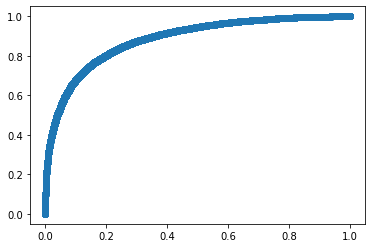

In [ ]:
Plot_AUC_Curve(predictions, y_valid)

## LGBM: 88.93

In [ ]:
# Set x and y
y = train_clean["target"]
lgbm_features = lgb_cat_features + list(cont_columns)
x = train_clean[lgbm_features]

x_train, x_valid, y_train, y_valid=train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# Use LGBM Classifier as first base model
lgbm = LGBMClassifier()

lgbm.fit(x_train, y_train,
         eval_set=(x_valid,y_valid),
         early_stopping_rounds=150, verbose=False)
predictions = lgbm.predict_proba(x_valid)[:,1]

auc = roc_auc_score(y_valid, predictions)

print(f'Baseline Score: {auc}')

Baseline Score: 0.8893417667451045


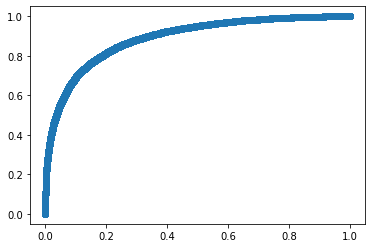

In [ ]:
Plot_AUC_Curve(predictions, y_valid)


## CatBoost: 88.83

In [ ]:
# Set x and y
y = train_clean["target"]
cb_features = cb_cat_features + list(cont_columns)
x = train_clean[cb_features]

x_train, x_valid, y_train, y_valid=train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# Fit Model
cat_cls = CatBoostClassifier(
    verbose = 1,
    eval_metric = 'AUC',
    loss_function = 'Logloss',
    task_type = 'GPU',
    cat_features = [x for x in range(len(cb_cat_features))]    
)

cat_cls.fit(x_train, y_train, verbose=False)
predictions = cat_cls.predict_proba(x_valid)[:,1]

auc = roc_auc_score(y_valid, predictions)

print(f'Baseline Score: {auc}')

Baseline Score: 0.8882935937104544


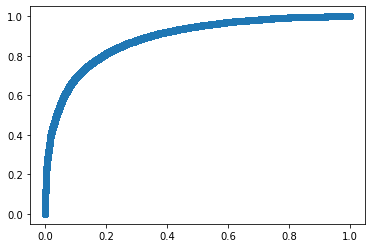

In [ ]:
Plot_AUC_Curve(predictions, y_valid)

## Ridge Model: 87.50

In [ ]:
# Set x and y
y = train_clean["target"]
ridge_features = ridge_cat_features + list(cont_columns)
x = train_clean[ridge_features]

x_train, x_valid, y_train, y_valid=train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# Fit Model
ridge_cls = RidgeClassifier(random_state=42)

ridge_cls.fit(x_train, y_train)
predictions = ridge_cls.decision_function(x_valid)

auc = roc_auc_score(y_valid, predictions)

print(f'Baseline Score: {auc}')

Baseline Score: 0.8749915125973005


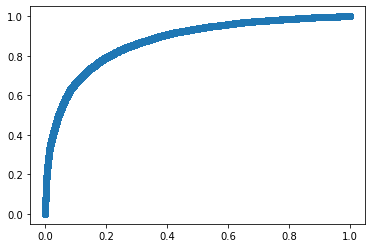

In [ ]:
Plot_AUC_Curve(predictions, y_valid)

# Essemble models


In [ ]:
# Prepare four different models for k-fold cross validation
random_state = 42
n_folds = 10
k_fold = StratifiedKFold(n_splits=n_folds,
                         random_state=random_state,
                         shuffle=True)

y = train_clean["target"]

# XGB model uses leave one out encoded cat features
xgb_train_preds = np.zeros(len(train_clean.index), )
xgb_test_preds = np.zeros(len(test_clean.index), )
xgb_features = xgb_cat_features + list(cont_columns)

# LGB model uses label encoded cat features
lgbm_train_preds = np.zeros(len(train_clean.index), )
lgbm_test_preds = np.zeros(len(test_clean.index), )
lgbm_features = lgb_cat_features + list(cont_columns)

# Cat Boost uses cat features as is
cb_train_preds = np.zeros(len(train_clean.index), )
cb_test_preds = np.zeros(len(test_clean.index), )
cb_features = cb_cat_features + list(cont_columns)

# Ridge uses leave one out encoded cat features
ridge_train_preds = np.zeros(len(train_clean.index), )
ridge_test_preds = np.zeros(len(test_clean.index), )
ridge_features = ridge_cat_features + list(cont_columns)

## K Fold Cross Validation, First Level

* XGB - ROC AUC Score = 0.8833
* LGB - ROC AUC Score = 0.8920
* CB - ROC AUC Score = 0.8895
* Ridge - ROC AUC Score = 0.875

In [ ]:
for fold, (train_index, valid_index) in enumerate(k_fold.split(train_clean, y)):
    print("--> Fold {}".format(fold + 1))
    y_train = y.iloc[train_index]
    y_valid = y.iloc[valid_index]

    ########## Generate train and valid sets ##########
    xgb_x_train = pd.DataFrame(train_clean[xgb_features].iloc[train_index])
    xgb_x_valid = pd.DataFrame(train_clean[xgb_features].iloc[valid_index])

    lgbm_x_train = pd.DataFrame(train_clean[lgbm_features].iloc[train_index])
    lgbm_x_valid = pd.DataFrame(train_clean[lgbm_features].iloc[valid_index])
    
    cb_x_train = pd.DataFrame(train_clean[cb_features].iloc[train_index])
    cb_x_valid = pd.DataFrame(train_clean[cb_features].iloc[valid_index])

    ridge_x_train = pd.DataFrame(train_clean[ridge_features].iloc[train_index])
    ridge_x_valid = pd.DataFrame(train_clean[ridge_features].iloc[valid_index])

    ########## XGBoost model ##########
    xgb_model = XGBClassifier(
        seed=random_state,
        verbosity=1,
        eval_metric="auc",
        tree_method="gpu_hist",
        gpu_id=0,
        n_jobs = 12,
    )
    xgb_model.fit(
        xgb_x_train,
        y_train,
        eval_set=[(xgb_x_valid, y_valid)], 
        verbose=0,
        early_stopping_rounds=200
    )

    train_oof_preds = xgb_model.predict_proba(xgb_x_valid)[:,1]
    test_oof_preds = xgb_model.predict_proba(test_clean[xgb_features])[:,1]
    xgb_train_preds[valid_index] = train_oof_preds
    xgb_test_preds += test_oof_preds / n_folds
    
    print(": XGB - ROC AUC Score = {}".format(roc_auc_score(y_valid, train_oof_preds, average="micro")))
    
    ########## LGBM model ##########
    lgbm_model = LGBMClassifier(
        cat_feature=[x for x in range(len(lgb_cat_features))],
        random_state=random_state,
        metric="auc",
        n_jobs=12,
    )
    lgbm_model.fit(
        lgbm_x_train,
        y_train,
        eval_set=[(lgbm_x_valid, y_valid)], 
        verbose=0,
    )

    train_oof_preds = lgbm_model.predict_proba(lgbm_x_valid)[:,1]
    test_oof_preds = lgbm_model.predict_proba(test_clean[lgbm_features])[:,1]
    lgbm_train_preds[valid_index] = train_oof_preds
    lgbm_test_preds += test_oof_preds / n_folds
    
    print(": LGB - ROC AUC Score = {}".format(roc_auc_score(y_valid, train_oof_preds, average="micro")))

    ########## CatBoost model ##########
    cb_model = CatBoostClassifier(
        verbose=0,
        eval_metric="AUC",
        loss_function="Logloss",
        random_state=random_state,
        task_type="GPU",
        devices="0",
        cat_features=[x for x in range(len(cb_cat_features))],
    )
    cb_model.fit(
        cb_x_train,
        y_train,
        eval_set=[(cb_x_valid, y_valid)], 
        verbose=0,
    )

    train_oof_preds = cb_model.predict_proba(cb_x_valid)[:,1]
    test_oof_preds = cb_model.predict_proba(test_clean[cb_features])[:,1]
    cb_train_preds[valid_index] = train_oof_preds
    cb_test_preds += test_oof_preds / n_folds
    
    print(": CB - ROC AUC Score = {}".format(roc_auc_score(y_valid, train_oof_preds, average="micro")))
    
    ########## Ridge model ##########
    ridge_model = RidgeClassifier(
        random_state=random_state,
    )
    ridge_model.fit(
        ridge_x_train,
        y_train,
    )

    train_oof_preds = ridge_model.decision_function(ridge_x_valid)
    test_oof_preds = ridge_model.decision_function(test_clean[ridge_features])
    ridge_train_preds[valid_index] = train_oof_preds
    ridge_test_preds += test_oof_preds / n_folds
    
    print(": Ridge - ROC AUC Score = {}".format(roc_auc_score(y_valid, train_oof_preds, average="micro")))
    print("")


print("--> Overall metrics")
print(": XGB - ROC AUC Score = {}".format(
    roc_auc_score(y, xgb_train_preds, average="micro")
))
print(": LGB - ROC AUC Score = {}".format(
    roc_auc_score(y, lgbm_train_preds, average="micro")
))
print(": CB - ROC AUC Score = {}".format(
    roc_auc_score(y, cb_train_preds, average="micro")
))
print(": Ridge - ROC AUC Score = {}".format(
    roc_auc_score(y, ridge_train_preds, average="micro")
))

--> Fold 1
: XGB - ROC AUC Score = 0.8817187098660038
: LGB - ROC AUC Score = 0.8905359287779799
: CB - ROC AUC Score = 0.8870812166398149
: Ridge - ROC AUC Score = 0.8738232810748878

--> Fold 2
: XGB - ROC AUC Score = 0.8834380641014523
: LGB - ROC AUC Score = 0.8920187460150613
: CB - ROC AUC Score = 0.8888588363217382
: Ridge - ROC AUC Score = 0.8748566232333965

--> Fold 3
: XGB - ROC AUC Score = 0.8812229328597396
: LGB - ROC AUC Score = 0.8907625052125333
: CB - ROC AUC Score = 0.8878478690533551
: Ridge - ROC AUC Score = 0.8732208995009413

--> Fold 4
: XGB - ROC AUC Score = 0.8830248362307551
: LGB - ROC AUC Score = 0.8916760124583569
: CB - ROC AUC Score = 0.8896774856745351
: Ridge - ROC AUC Score = 0.8741859186399463

--> Fold 5
: XGB - ROC AUC Score = 0.885059427616871
: LGB - ROC AUC Score = 0.8942221619674527
: CB - ROC AUC Score = 0.891589982403898
: Ridge - ROC AUC Score = 0.877637135593158

--> Fold 6
: XGB - ROC AUC Score = 0.8837433606607911
: LGB - ROC AUC Score = 

In [ ]:
#save results
os.getcwd()

path = '/gdrive/MyDrive/Kaggle/Tabular Playground Series - Mar 2021/Results and Submissions'

np.save('/'.join([path, 'xgb_train']),xgb_train_preds)
np.save('/'.join([path, 'lgbm_train']),lgbm_train_preds)
np.save('/'.join([path, 'cb_train']),cb_train_preds)
np.save('/'.join([path, 'ridge_train']),ridge_train_preds)

np.save('/'.join([path, 'xgb_test']),xgb_train_preds)
np.save('/'.join([path, 'lgbm_test']),lgbm_test_preds)
np.save('/'.join([path, 'cb_test']),cb_test_preds)
np.save('/'.join([path, 'ridge_test']),ridge_test_preds)


## Manual Blended classification


In [ ]:
#Manually choose weightings, drop Ridge
y_train_preds = (
    0.3 * xgb_train_preds +
    0.4 * lgbm_train_preds +
    0.3 * cb_train_preds
)

print(": Essemble train test - ROC AUC Score = {}".format(
    roc_auc_score(y, y_train_preds, average="micro")
))

y_test_preds = (
    0.3 * xgb_test_preds +
    0.4 * lgbm_test_preds +
    0.3 * cb_test_preds
)

sample_sub['target'] = y_test_preds
sample_sub.to_csv('/'.join([path, 'submission_base_essemble.csv']),index=False)


: Essemble train test - ROC AUC Score = 0.8909404471050102


# Second Level Classification

In [ ]:
random_state = 42
n_folds = 10
k_fold = StratifiedKFold(n_splits=n_folds, random_state=random_state, shuffle=True)

y = train_clean['target']

l1_train = pd.DataFrame(data={
    "xgb": xgb_train_preds.tolist(),
    "lgbm": lgbm_train_preds.tolist(),
    "cb": cb_train_preds.tolist(),
    "ridge": ridge_train_preds.tolist(),
    "target": y.tolist()
})

l1_test = pd.DataFrame(data={
    "xgb": xgb_test_preds.tolist(),
    "lgbm": lgbm_test_preds.tolist(),
    "cb": cb_test_preds.tolist(),
    "ridge": ridge_test_preds.tolist(),    
})

train_preds = np.zeros(len(l1_train.index), )
test_preds = np.zeros(len(l1_test.index), )
features = ["xgb", "lgbm", "cb", "ridge"]

for fold, (train_index, valid_index) in enumerate(k_fold.split(l1_train, y)):
    print("--> Fold {}".format(fold + 1))
    y_train = y.iloc[train_index]
    y_valid = y.iloc[valid_index]

    x_train = pd.DataFrame(l1_train[features].iloc[train_index])
    x_valid = pd.DataFrame(l1_train[features].iloc[valid_index])
    
    model = CalibratedClassifierCV(
        RidgeClassifier(random_state=random_state), 
        cv=3
    )
    model.fit(
        x_train,
        y_train,
    )

    train_oof_preds = model.predict_proba(x_valid)[:,-1]
    test_oof_preds = model.predict_proba(l1_test[features])[:,-1]
    train_preds[valid_index] = train_oof_preds
    test_preds += test_oof_preds / n_folds
    
    print(": ROC AUC Score = {}".format(roc_auc_score(y_valid, train_oof_preds, average="micro")))
    print("")
    
print("--> Overall metrics")
print(": ROC AUC Score = {}".format(roc_auc_score(y, train_preds, average="micro")))

--> Fold 1
: ROC AUC Score = 0.8907889259575682

--> Fold 2
: ROC AUC Score = 0.8922990627015296

--> Fold 3
: ROC AUC Score = 0.8915431440723113

--> Fold 4
: ROC AUC Score = 0.8924845272013953

--> Fold 5
: ROC AUC Score = 0.8949637917099393

--> Fold 6
: ROC AUC Score = 0.8918673602817933

--> Fold 7
: ROC AUC Score = 0.8933580552377776

--> Fold 8
: ROC AUC Score = 0.8907186456344905

--> Fold 9
: ROC AUC Score = 0.8956073508424544

--> Fold 10
: ROC AUC Score = 0.89312838100185

--> Overall metrics
: ROC AUC Score = 0.8926600181506125


# Hyper parameter tuning with Optuna

In [ ]:
#Tune LGB model since consistently highest AUC

def objective(trial, X=train_clean[lgbm_features], y=y, meta_random_seed = 42):

  X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.2,random_state=meta_random_seed)

  lgb_params={
      'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2),
      'max_depth': trial.suggest_int('max_depth', 6, 200),
      'num_leaves': trial.suggest_int('num_leaves', 31, 120),
      'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0),
      'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0),
      'random_state': meta_random_seed,
      'metric': 'auc',
      'n_estimators': trial.suggest_int('n_estimators', 6, 300000),
      'n_jobs': 12,
      'cat_feature': [x for x in range(len(cat_columns))],
      'bagging_seed': 2021,
      'feature_fraction_seed': 2021,
      'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 0.9),
      'min_child_samples': trial.suggest_int('min_child_samples', 1, 500),
      'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
      'subsample': trial.suggest_float('subsample', 0.3, 0.9),
      'max_bin': trial.suggest_int('max_bin', 128, 1024),
      'min_data_per_group': trial.suggest_int('min_data_per_group', 50, 350),
      'cat_smooth': trial.suggest_int('cat_smooth', 10, 250),
      'cat_l2': trial.suggest_int('cat_l2', 1, 20)
  }

  lgb = LGBMClassifier(
      **lgb_params
  )
  
  lgb.fit(
      X_train,
      y_train,
      eval_set=(X_valid,y_valid),
      eval_metric='auc',
      early_stopping_rounds=100,
      verbose=False
  )

  predictions=lgb.predict_proba(X_valid)[:,1]

  return roc_auc_score(y_valid,predictions)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=3600*7, n_trials=15)

[I 2021-03-23 15:28:15,613] A new study created in memory with name: no-name-fad9d58e-e7f0-461e-b366-ff611a08c682
[I 2021-03-23 15:33:48,426] Trial 0 finished with value: 0.8971520973319906 and parameters: {'learning_rate': 0.006786406114306524, 'max_depth': 10, 'num_leaves': 49, 'reg_alpha': 7.18520826715226, 'reg_lambda': 3.8109203540198067, 'n_estimators': 197006, 'colsample_bytree': 0.26964063096272617, 'min_child_samples': 140, 'subsample_freq': 3, 'subsample': 0.4972731841894771, 'max_bin': 166, 'min_data_per_group': 160, 'cat_smooth': 12, 'cat_l2': 6}. Best is trial 0 with value: 0.8971520973319906.
[I 2021-03-23 15:40:20,204] Trial 1 finished with value: 0.8966528747869886 and parameters: {'learning_rate': 0.005759410861659484, 'max_depth': 22, 'num_leaves': 98, 'reg_alpha': 7.776144748979597, 'reg_lambda': 3.2485130414362215, 'n_estimators': 297264, 'colsample_bytree': 0.657468335072982, 'min_child_samples': 36, 'subsample_freq': 5, 'subsample': 0.33432501249944235, 'max_bin':

In [ ]:
study.best_params


{'cat_l2': 20,
 'cat_smooth': 214,
 'colsample_bytree': 0.3315180208179222,
 'learning_rate': 0.004277549026567215,
 'max_bin': 606,
 'max_depth': 167,
 'min_child_samples': 162,
 'min_data_per_group': 267,
 'n_estimators': 261317,
 'num_leaves': 81,
 'reg_alpha': 7.942324971676128,
 'reg_lambda': 0.511460245836029,
 'subsample': 0.6512684717168147,
 'subsample_freq': 10}

In [ ]:
!pip install joblib
import joblib
import pickle

path = '/gdrive/MyDrive/Kaggle/Tabular Playground Series - Mar 2021/Results and Submissions'


joblib.dump(study, '/'.join([path, 'lgb_study.pkl']))



['/gdrive/MyDrive/Kaggle/Tabular Playground Series - Mar 2021/Results and Submissions/lgb_study.pkl']

## LGM Model with optimized hyperparameters

In [ ]:
path = '/gdrive/MyDrive/Kaggle/Tabular Playground Series - Mar 2021/Results and Submissions'

study = joblib.load('/'.join([path, 'lgb_study.pkl']))

lgb_opt_params = {**study.best_params, **{
    'random_state': 32,
    'metric': 'auc',
    'n_jobs': 12,
    'cat_feature': [x for x in range(len(cat_columns))],
    'bagging_seed': 2021,
    'feature_fraction_seed': 2021}}

print(lgb_opt_params)

{'learning_rate': 0.004277549026567215, 'max_depth': 167, 'num_leaves': 81, 'reg_alpha': 7.942324971676128, 'reg_lambda': 0.511460245836029, 'n_estimators': 261317, 'colsample_bytree': 0.3315180208179222, 'min_child_samples': 162, 'subsample_freq': 10, 'subsample': 0.6512684717168147, 'max_bin': 606, 'min_data_per_group': 267, 'cat_smooth': 214, 'cat_l2': 20, 'random_state': 32, 'metric': 'auc', 'n_jobs': 12, 'cat_feature': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], 'bagging_seed': 2021, 'feature_fraction_seed': 2021}


In [ ]:
########## Set up cross val ##########
random_state = 42
n_folds = 10
k_fold = StratifiedKFold(n_splits=n_folds, random_state=random_state, shuffle=True)
y = train_clean["target"]

########## 
lgbm_opt_train_preds = np.zeros(len(train_clean.index), )
lgbm_opt_test_preds = np.zeros(len(test_clean.index), )

for fold, (train_index, valid_index) in enumerate(k_fold.split(train_clean, y)):
  print("--> Fold {}".format(fold + 1))
  y_train = y.iloc[train_index]
  y_valid = y.iloc[valid_index]

  ########## LGBM Optimized X and Y ##############
  lgbm_x_train = pd.DataFrame(train_clean[lgbm_features].iloc[train_index])
  lgbm_x_valid = pd.DataFrame(train_clean[lgbm_features].iloc[valid_index])

  ########## LGBM Optimized model ##########
  lgbm_opt_model = LGBMClassifier(
      **lgb_opt_params
  )

  ########## LGBM Optimized Fit ###############
  lgbm_opt_model.fit(
      lgbm_x_train,
      y_train,
      eval_set=[(lgbm_x_valid, y_valid)], 
      eval_metric='auc',
      early_stopping_rounds=200,
      verbose=0,
  )

  ########## Collect Out of Fold predictions ####
  train_oof_preds = lgbm_model.predict_proba(lgbm_x_valid)[:,1]
  test_oof_preds = lgbm_model.predict_proba(test_clean[lgbm_features])[:,1]
  lgbm_opt_train_preds[valid_index] = train_oof_preds
  lgbm_opt_test_preds += test_oof_preds / n_folds

  sample_sub['target'] = lgbm_opt_test_preds
  save_file_name = f'lgbm_opt_{fold}.csv'
  sample_sub.to_csv('/'.join([path, save_file_name]),index=False)

  print(": LGB - ROC AUC Score = {}".format(roc_auc_score(y_valid, train_oof_preds, average="micro")))


sample_sub['target'] = lgbm_opt_test_preds
sample_sub.to_csv('/'.join([path, 'lgbm_opt.csv']),index=False)


--> Fold 1
: LGB - ROC AUC Score = 0.8996460670147416
--> Fold 2
: LGB - ROC AUC Score = 0.9004835875130743
--> Fold 3
: LGB - ROC AUC Score = 0.8989699099327644
--> Fold 4
: LGB - ROC AUC Score = 0.9003322417247772
--> Fold 5
: LGB - ROC AUC Score = 0.902690595659634
--> Fold 6
: LGB - ROC AUC Score = 0.8999689079759401
--> Fold 7
: LGB - ROC AUC Score = 0.9011589628149071
--> Fold 8
: LGB - ROC AUC Score = 0.8988345278667643
--> Fold 9
: LGB - ROC AUC Score = 0.9031854339590824
--> Fold 10
: LGB - ROC AUC Score = 0.8921953587098029
